# Project 3: Identifying Depression in r/domesticviolence Subreddit Posts
<img src="./images/domestic_violence.jpg" alt="domestic violence pic"/>

- [Webscraping and Data Collection](./1_Webscraping_and_Data_Collection.ipynb)
- [Preprocessing and EDA](./2_Preprocessing_and_EDA.ipynb)
- [Modeling - Multinomial Naive Bayes](./3_Modeling_Multinomial_Naive_Bayes.ipynb)
- <b>Modeling - Logistic Regression</b>
- [Modeling - Random Forest](./5_Modeling_Random_Forest.ipynb)
- [Production Model and Insights](./6_Production_Model_and_Insights.ipynb)

---
## Overview

Based on the features in the cleaned dataframe, I will now fit each feature, vectorized by Count Vectorization or TF-IDF Vectorization to a Logistic Regression model. I will then take the best performing model and optimise its hyperparameters and fit the model again. From there, I will be able to glean insights about the coefficient of each word in the model and how much it affects the prediction of the target vector (```is_depression```). The best model will be taken into consideration for the final production model. 

---
## Contents
- [Importing libraries and data](#Importing-libraries-and-data)
- [Logistic regression model](#Logistic-regression-model)
- [Optimising parameters](#Optimising-parameters-for-logistic-regression-model)
- [Insights](#Insights-from-logistic-regression-model)
- [Conclusion](#Conclusion)

---
## Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [2]:
model_df = pd.read_csv('./data/dv_depression_cleaned_for_model_final.csv')
model_df.head()

,is_depression,post,title,post_word_count,all_words
0,0,unless get extremely stoned often come stop th...,get intrusive thoughts memories physical abuse,261,get intrusive thoughts memories physical abuse...
1,1,saw george floyd clip know part cries mama mad...,kids afraid crying,363,kids afraid crying saw george floyd clip know ...
2,1,sexual relationships since lost virginity bu s...,nicotine replaced sexual urges,383,nicotine replaced sexual urges sexual relation...
3,1,well end year 5 days hand rest school work don...,hate school disappointment,613,hate school disappointment well end year 5 day...
4,1,anyone suffering depression job looking simple...,suffering depression job,61,suffering depression job anyone suffering depr...


In [3]:
#no null values
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_depression    1958 non-null   int64 
 1   post             1958 non-null   object
 2   title            1958 non-null   object
 3   post_word_count  1958 non-null   int64 
 4   all_words        1958 non-null   object
dtypes: int64(2), object(3)
memory usage: 76.6+ KB


---
## Logistic regression model

I created functions that would run and return the performance of a Count Vectorization with Logistic Regression model and TF-IDF Vectorization with Logistic Regression model on all feature columns, i.e., ```title```(words in title), ```post```(words in post), ```all_words```(all words in title and post). The dataframes below show the performance of each feature matrix.

The best model was TF-IDF Vectorization with Logistic Regression model with the ```all_words``` column as the feature matrix

It has the highest accuracy score and least variance between train and test scores. It also has the highest sensitivity, specificity, precision, ROC AUC score and f1-score

In [4]:
def cvec_lr_model(list_of_col):

    results_list = []
    for col in list_of_col:
    
    #features matrix(X) and target vector(y)
        X = model_df[col]
        y = model_df['is_depression']

        #train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify=y, 
                                                            random_state = 42)

        #instantiate cvec
        cvec = CountVectorizer()

        #fit and transform
        X_train = cvec.fit_transform(X_train).todense()
        X_test = cvec.transform(X_test).todense()

        #instantiate multinomial nb
        lr = LogisticRegression()

        #fit nb 
        lr.fit(X_train, y_train)

        #preds from nb model 
        pred = lr.predict(X_test)

        #generate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

        #calculate roc auc score 
        pred_proba = [i[1] for i in lr.predict_proba(X_test)]
        roc = roc_auc_score(y_test, pred_proba)

        #create table of results using dictionary
        results = {}
        results['features matrix (X)'] = col
        results['model'] = 'cvec + logistic regression'
        results['train accuracy score'] = lr.score(X_train, y_train)
        results['test accuracy score'] = lr.score(X_test, y_test)
        results['confusion matrix'] = {'tn':tn, 'fp': fp, 'fn': fn, 'tp': tp}
        results['sensitivity'] = tp/(tp+fn)
        results['specificity'] = tn/(tn+fp)
        results['precision'] = tp/(tp+fp)
        results['roc auc score'] = roc
        results['train f1-score'] = f1_score((lr.predict(X_train)), y_train)
        results['test f1-score'] = f1_score(pred, y_test)

        results 
        
        #append results dict to results_list
        results_list.append(results)
        
    #return dataframe of results for each model
    return(pd.DataFrame(results_list)).round(2)

In [5]:
def tvec_lr_model(list_of_col):

    results_list = []
    for col in list_of_col:
    
    #features matrix(X) and target vector(y)
        X = model_df[col]
        y = model_df['is_depression']

        #train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify=y, 
                                                            random_state = 42)

        #instantiate cvec
        tvec = TfidfVectorizer()

        #fit and transform
        X_train = tvec.fit_transform(X_train).todense()
        X_test = tvec.transform(X_test).todense()

        #instantiate multinomial nb
        lr = LogisticRegression()

        #fit nb 
        lr.fit(X_train, y_train)

        #preds from nb model 
        pred = lr.predict(X_test)

        #generate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

        #calculate roc auc score 
        pred_proba = [i[1] for i in lr.predict_proba(X_test)]
        roc = roc_auc_score(y_test, pred_proba)

        #create table of results using dictionary
        results = {}
        results['features matrix (X)'] = col
        results['model'] = 'tvec + logistic regression'
        results['train accuracy score'] = lr.score(X_train, y_train)
        results['test accuracy score'] = lr.score(X_test, y_test)
        results['confusion matrix'] = {'tn':tn, 'fp': fp, 'fn': fn, 'tp': tp}
        results['sensitivity'] = tp/(tp+fn)
        results['specificity'] = tn/(tn+fp)
        results['precision'] = tp/(tp+fp)
        results['roc auc score'] = roc
        results['train f1-score'] = f1_score((lr.predict(X_train)), y_train)
        results['test f1-score'] = f1_score(pred, y_test)

        results 
        
        #append results dict to results_list
        results_list.append(results)
        
    #return dataframe of results for each model
    return(pd.DataFrame(results_list)).round(2)

**Count Vectorization involves counting the number of occurrences each words appears in a document**

In [6]:
cvec_lr_model(['title', 'post', 'all_words'])

,features matrix (X),model,train accuracy score,test accuracy score,confusion matrix,sensitivity,specificity,precision,roc auc score,train f1-score,test f1-score
0,title,cvec + logistic regression,0.94,0.79,"{'tn': 189, 'fp': 61, 'fn': 41, 'tp': 199}",0.83,0.76,0.77,0.88,0.94,0.80
1,post,cvec + logistic regression,0.99,0.90,"{'tn': 212, 'fp': 38, 'fn': 9, 'tp': 231}",0.96,0.85,0.86,0.97,0.99,0.91
2,all_words,cvec + logistic regression,1.00,0.94,"{'tn': 228, 'fp': 22, 'fn': 8, 'tp': 232}",0.97,0.91,0.91,0.98,1.00,0.94


**Term Frequency-Inverse Document Frequency (TF-IDF) tells whether a word appears frequently in some posts and less frequently in others**

In [7]:
tvec_lr_model(['title', 'post', 'all_words'])

,features matrix (X),model,train accuracy score,test accuracy score,confusion matrix,sensitivity,specificity,precision,roc auc score,train f1-score,test f1-score
0,title,tvec + logistic regression,0.93,0.81,"{'tn': 201, 'fp': 49, 'fn': 44, 'tp': 196}",0.82,0.80,0.80,0.88,0.93,0.81
1,post,tvec + logistic regression,0.97,0.92,"{'tn': 224, 'fp': 26, 'fn': 13, 'tp': 227}",0.95,0.90,0.90,0.98,0.97,0.92
2,all_words,tvec + logistic regression,0.98,0.94,"{'tn': 232, 'fp': 18, 'fn': 9, 'tp': 231}",0.96,0.93,0.93,0.98,0.98,0.94


#### The best model is TF-IDF Vectorization with logistic regression with the ```all_words``` column as the feature matrix. 
It has the highest accuracy score and least variance between train and test scores. It also has the highest sensitivity,	specificity,	precision,	ROC AUC score and  f1-score (also least variance betweem train and test)

---
## Optimising parameters for logistic regression model
Since we have already found the best combination of features matrix and model, I will now optimise the hyperparameters of the chosen model, before fitting and calculating the performance of the model with these metrics, as seen in the dataframe below:
- Accuracy score
- ROC AUC score
- Sensitivity score
- Specificity score 
- Precision score
- f1-score

I have limited the ```max_features``` to 500 so that the 40 most significant features can be differentiated by their coefficients (in Insight section), while not significantly affecting the scores of the model

In [8]:
#features matrix and target vector
X = model_df['all_words']
y = model_df['is_depression']

#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, 
                                                    random_state = 42)

#optimising hyperparameters 
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'tvec__max_features': [100, 200, 500],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_df': [0.2, 0.3, 0.7],
    'tvec__ngram_range': [(1,1)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(-5, 1, 10)
}

gscv = GridSearchCV(pipe, pipe_params, cv=5, n_jobs =-1, verbose=1)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  7.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [9]:
gscv.best_params_

{'lr__C': 2.154434690031882,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.7,
 'tvec__max_features': 500,
 'tvec__min_df': 6,
 'tvec__ngram_range': (1, 1)}

In [10]:
#fitting model with optimised params 
best_gscv = gscv.best_estimator_
best_gscv.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=500,
                                 min_df=6, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=2.154434690031882, class_weight=None,
                                    dual=False, fit_intercept=True,
      

In [11]:
#create dataframe of metrics based on optimised model 
opt_results = pd.DataFrame()

opt_results['features_matrix'] = ['all_words']
opt_results['model'] = ['tvec + logistic regression']
opt_results['optimised_params'] = [gscv.best_params_]
opt_results['train_score'] = best_gscv.score(X_train, y_train)
opt_results['test_score'] = best_gscv.score(X_test, y_test)

preds = best_gscv.predict(X_test)
tn, fp, fn, tp = cm = confusion_matrix(y_test, preds).ravel()

opt_results['confusion_matrix'] = [f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}']
opt_results['sensitivity'] = tp/(tp+fn)
opt_results['specificity'] = tn/(tn+fp)
opt_results['precision'] = tp/(tp+fp)

pred_proba = [i[1] for i in best_gscv.predict_proba(X_test)]

opt_results['roc_auc_score'] = roc_auc_score(y_test, pred_proba)
opt_results['train_f1'] = f1_score((best_gscv.predict(X_train)), y_train)
opt_results['test_f1'] = f1_score(preds, y_test)

pd.set_option('display.max_colwidth', None)
opt_results.T

,0
features_matrix,all_words
model,tvec + logistic regression
optimised_params,"{'lr__C': 2.154434690031882, 'lr__penalty': 'l2', 'tvec__max_df': 0.7, 'tvec__max_features': 500, 'tvec__min_df': 6, 'tvec__ngram_range': (1, 1)}"
train_score,0.969346
test_score,0.936735
confusion_matrix,"tn: 229, fp: 21, fn: 10, tp: 230"
sensitivity,0.958333
specificity,0.916
precision,0.916335
roc_auc_score,0.980483


In [12]:
#export opt_results for use in final model 
opt_results.to_csv('./data/best_logistic_regression.csv', index=False)

### ROC curve
The ROC curve shows how well the model is at interpreting classes (0 and 1). The more area between the ROC (blue) curve and baseline (yellow line), the better separated the distributions of 0 and 1.
An ROC AUC score of 0.976 means that the distribution is well separated, there is little overlap between false positive and false negatives, therefore minimising wrong predictions

In [13]:
pred_df = pd.DataFrame({'true_values': y_test,'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
353,0,0.001879
1954,0,0.087163
703,0,0.124537
910,0,0.113748
1525,0,0.200588


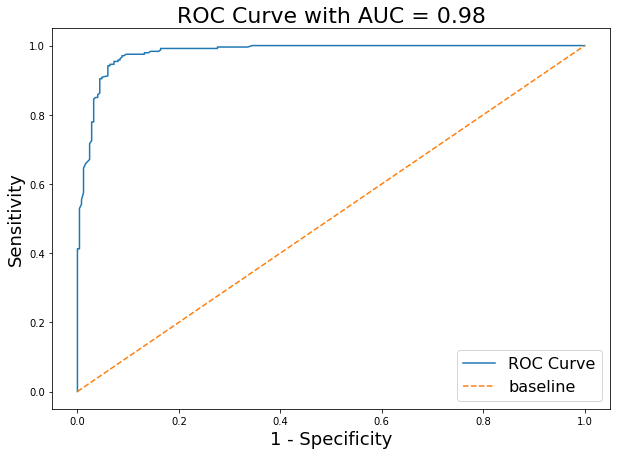

In [14]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

---
## Insights from logistic regression model

### Words with largest coefficient values 

From the top 500 most significant words (```max_features```), I have plotted a bar graph to show which words affect the prediction of target vector ```is_depression``` the most.

**The top 20 words have the largest positive coefficient values. They POSITVELY affect the probability of ```is_depression``` the most.**
- The top 20 words are: ```depression, depressed, life, shit, better, suicide, fucking, suicidal, people, wanna, feeling, wish, hate, die, friends, anymore, dont, happy, anxiety, tired```
- As word count of ```depression``` increases by 1, the probability of target vector ```is_depression``` is increased by 5.01 times, i.e., higher probability of belonging in r/depression subreddit

**The bottom 20 words have the largest negative coefficient values. They NEGATIVELY affect the probability of ```is_depression``` the most.**
- The bottom 20 words are: ```abuse, abusive, abuser, violence, police, ex, leave, domestic, hit, relationship, abusedm order, violent, husband, boyfriend, hurt, together, physical, advice, court ```
- As word count of ```abusive``` increases by 1, the probability of target vector ```is_depression``` is reduced by  5.29 times, i.e., higher probability of belonging in r/domesticviolence subreddit 


In [15]:
#finding coefficients of 500 most siginificant features from model 
coefs = best_gscv.named_steps['lr'].coef_
coefs.shape

(1, 500)

In [16]:
features = best_gscv.named_steps['tvec'].get_feature_names()
len(features)

500

In [17]:
#creating dataframe of words and coefficients 
coef_df = pd.DataFrame({'word':features, 'coef':coefs[0]})
coef_df.head()

,word,coef
0,10,-0.749787
1,20,-0.264341
2,able,0.185237
3,abuse,-5.297267
4,abused,-2.389072


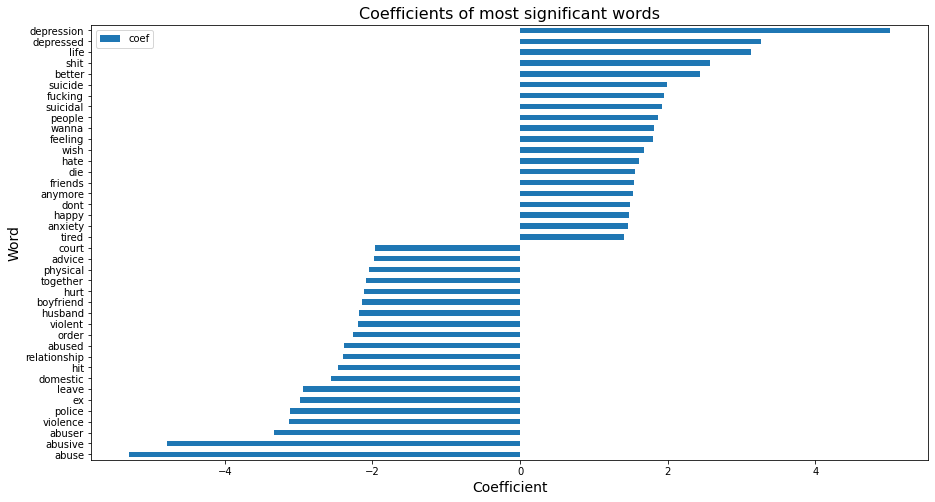

In [18]:
#words with largest positive coefficient values 
top_20 = coef_df.sort_values(by = 'coef', ascending = False)[0:20]

#words with largest negative coefficient values 
bottom_20 = coef_df.sort_values(by = 'coef')[0:20] 

top_bottom_20 = pd.concat([bottom_20, top_20.sort_values(by = 'coef')], axis =0)

#plot bar chart with 20 words with largest coefficient values and 20 words with smallest coefficient values 
top_bottom_20.plot.barh('word', figsize=(15,8))
plt.title ('Coefficients of most significant words', fontsize=16)
plt.xlabel('Coefficient', fontsize = 14)
plt.ylabel('Word', fontsize = 14);

---
## Conclusion 

The best feature for logistic regression model was the ```all_words``` column, vectorized with ```TF-IDFVectorizer```. It gave a train accuracy score of 0.97 and test accuracy score of 0.92. Its low variance also suggests that the model is not overfit and will generalise well to unseen data. The ROC AUC score of 0.98 means that there is little overlap between false positive and false negatives, thereby minimising wrong predictions. 

This model will be taken into consideration for the final production model. 

#### Pros and Cons of Logistic Regression model
- Pros
    - Low variance 
    - Able to generate coefficients so weightage of each feature can be measured 
- Cons
    - Tendency to have high bias - which is not the case here since the hyperparameters for the model were optimised 
    
#### The next notebook will explore Random Forest classification modeling